In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier 
from utils.functions import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import optuna
import shap
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Part I: Find predictors of influence

In [4]:
# Read data
data = pd.read_csv('data/train.csv')
data.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,11355.000000,34463,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,1330.366048,39262,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,5999.896907,3622,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,96.166667,19562,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,2833.847943,7554,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


### Exploratory data analysis

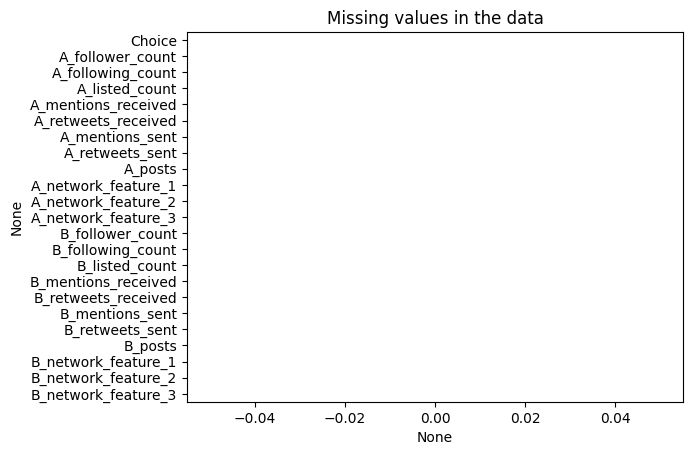

In [5]:
# Exploratory data analysis

sns.barplot(x = data.isna().mean(), y = data.isna().mean().index)
plt.title('Missing values in the data')
plt.show()

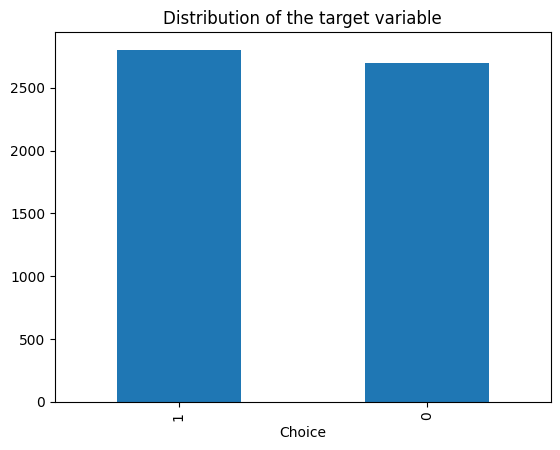

In [6]:
data['Choice'].value_counts().plot(kind = 'bar')
plt.title('Distribution of the target variable')
plt.show()

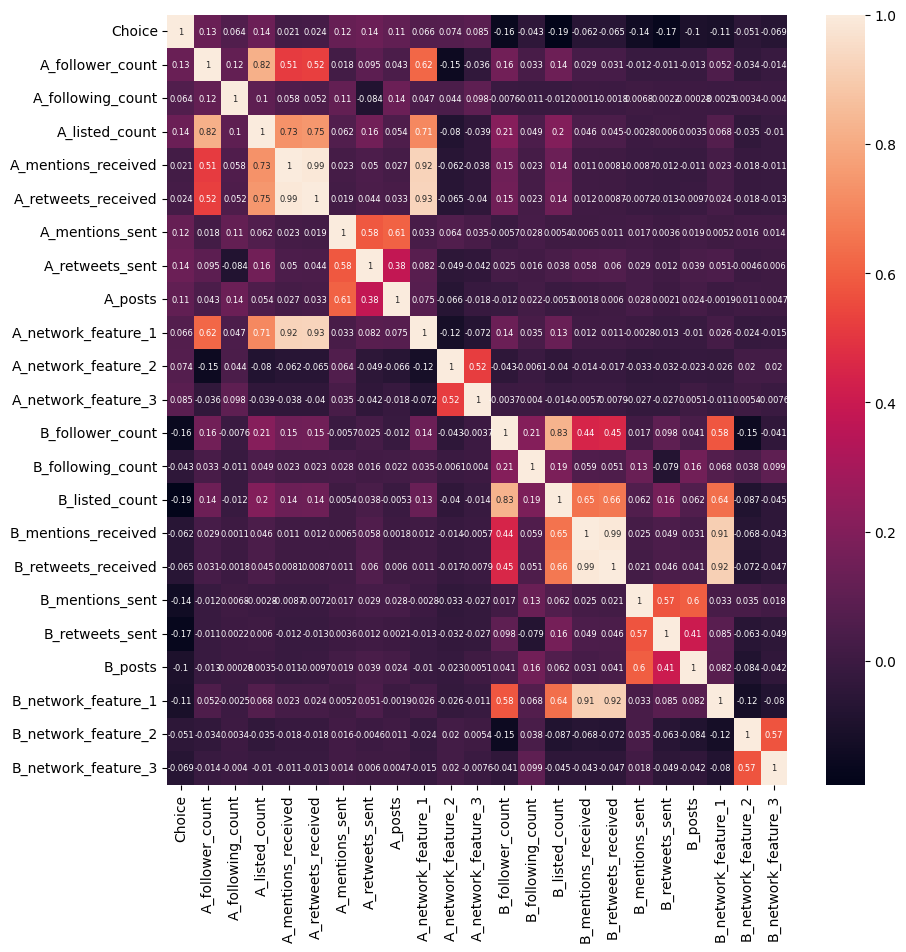

In [7]:
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr(), annot = True, annot_kws={'size': 6})
plt.show()

### Feature engineering

In [8]:
## Creation of new features
data['A_follow_ratio'] = data['A_follower_count'] / data['A_following_count']
data['B_follow_ratio'] = data['B_follower_count'] / data['B_following_count']
data['A_B_follow_ratio'] = data['A_follow_ratio'] / data['B_follow_ratio']

data['A_mention_ratio'] = data['A_mentions_received'] / data['A_mentions_sent']
data['B_mention_ratio'] = data['B_mentions_received'] / data['B_mentions_sent']
data['A_B_mention_ratio'] = data['A_mention_ratio'] / data['B_mention_ratio']

data['A_retweet_ratio'] = data['A_retweets_received'] / data['A_retweets_sent']
data['B_retweet_ratio'] = data['B_retweets_received'] / data['B_retweets_sent']
data['A_B_retweet_ratio'] = data['A_retweet_ratio'] / data['B_retweet_ratio']


data['A_B_followers_ratio'] = data['A_follower_count'] / data['B_follower_count']
data['A_B_following_ratio'] = data['A_following_count'] / data['B_following_count']
data['A_B_posts_ratio'] = data['A_posts'] / data['B_posts']
data['A_B_listed_ratio'] = data['A_listed_count'] / data['B_listed_count']
data['A_B_mentions_received_ratio'] = data['A_mentions_received'] / data['B_mentions_received']
data['A_B_mentions_sent_ratio'] = data['A_mentions_sent'] / data['B_mentions_sent']
data['A_B_retweets_received_ratio'] = data['A_retweets_received'] / data['B_retweets_received']
data['A_B_retweets_sent_ratio'] = data['A_retweets_sent'] / data['B_retweets_sent']
data['A_B_network_feature_1_ratio'] = data['A_network_feature_1'] / data['B_network_feature_1']
data['A_B_network_feature_2_ratio'] = data['A_network_feature_2'] / data['B_network_feature_2']
data['A_B_network_feature_3_ratio'] = data['A_network_feature_3'] / data['B_network_feature_3']

data = data.replace([np.inf, -np.inf], np.nan)

### Modeling

In [113]:
VARS = [
    'A_B_follow_ratio',
    'A_B_mention_ratio',
    'A_B_retweet_ratio',
    'A_B_followers_ratio',
    'A_B_following_ratio',
    'A_B_posts_ratio',
    'A_B_listed_ratio',
    'A_B_mentions_received_ratio',
    'A_B_mentions_sent_ratio',
    'A_B_retweets_received_ratio',
    'A_B_retweets_sent_ratio',
    'A_B_network_feature_1_ratio',
    'A_B_network_feature_2_ratio',
    'A_B_network_feature_3_ratio'
    ]

TARGET = ['Choice']

In [114]:
x = data[VARS]
y = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)


In [115]:
model_list = {
    'xgb':XGBClassifier(random_state = 123),
    'catboost':CatBoostClassifier(random_state = 123, verbose = False),
    'lgbm':LGBMClassifier(random_state = 123, verbose = -1),
    'randomForest':RandomForestClassifier(random_state = 123)
    }

list_metrics = []
for i in model_list.values():
    model = i
    model, metrics, cm = main_process(model,x_train, y_train, x_test, y_test, False, 0.5)
    list_metrics.append(metrics['auc'])

Text(0.5, 1.0, 'AUC score for different models')

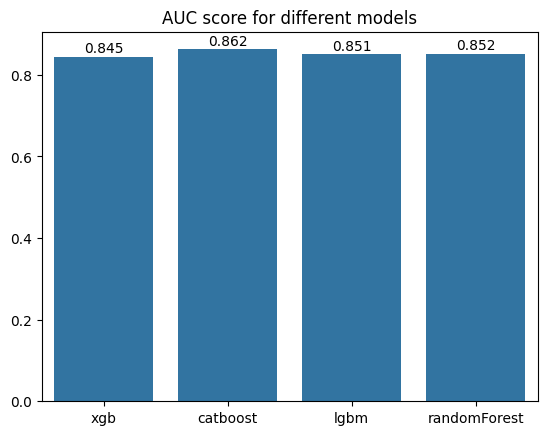

In [116]:
a = sns.barplot(x = list(model_list.keys()), y = list_metrics)

for i in range(len(list_metrics)):
    a.text(i, round(list_metrics[i],3) + 0.01, round(list_metrics[i],3), color='black', ha="center")
plt.title('AUC score for different models')

### Hyperparameter calibration

In [82]:
### Create validation set

x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, x_training, y_training, x_val, y_val), n_trials=100)

[I 2024-03-24 00:05:34,000] A new study created in memory with name: no-name-afa679ff-2346-4ccb-9311-309b1f965bce
[I 2024-03-24 00:05:34,127] Trial 0 finished with value: 0.8481508264462809 and parameters: {'objective': 'CrossEntropy', 'depth': 6, 'learning_rate': 0.08683670254645753, 'n_estimators': 8992, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.07475305313217372, 'subsample': 0.263786151088403}. Best is trial 0 with value: 0.8481508264462809.
[I 2024-03-24 00:05:35,914] Trial 1 finished with value: 0.8495712809917355 and parameters: {'objective': 'CrossEntropy', 'depth': 11, 'learning_rate': 0.01336029122587095, 'n_estimators': 3838, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.09843195463709552}. Best is trial 1 with value: 0.8495712809917355.
[I 2024-03-24 00:05:37,147] Trial 2 finished with value: 0.8481611570247936 and parameters: {'objective': 'CrossEntropy', 'depth': 4, 'learning_rate': 0.0204610091584059, 'n

### Optimizing threshold

In [117]:
best_params = {
    'objective': 'CrossEntropy',
    'depth': 10,
    'learning_rate': 0.054142680909405445,
    'n_estimators': 7625,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'colsample_bylevel': 0.08320979403660492,
    'subsample': 0.6592979938870895
    }

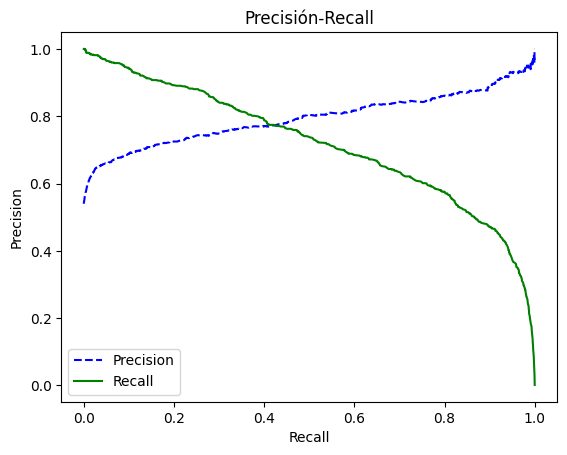

In [118]:
model = CatBoostClassifier(**best_params, random_state = 123, verbose = False)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
model = training(model, x_train, y_train)
preds,probas = predict(model, x_test, 0.5)
precision, recall, threshold = plot_precision_recall(y_test, probas)

In [120]:
final_threshold = threshold[np.argmax(recall == precision)]
final_threshold

0.42269300878539556

### Final model

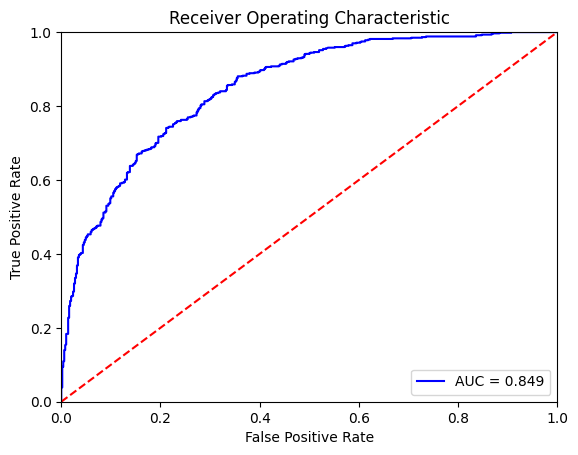

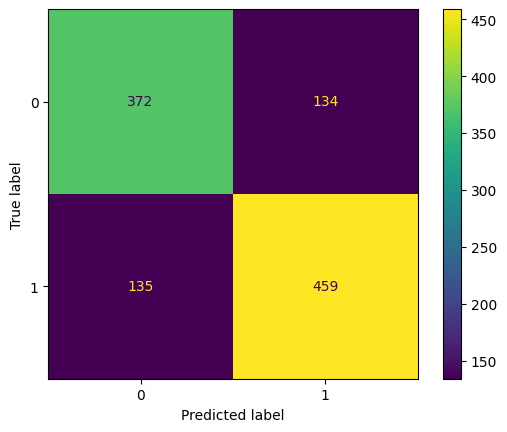

{'accuracy': 0.7554545454545455, 'sensitivity': 0.7727272727272727, 'specificity': 0.7351778656126482, 'auc': 0.8494713272381257}


In [122]:
final_model, metrics, cm = main_process(model, x_train, y_train, x_test, y_test, True, final_threshold, True)
print(metrics)

In [156]:
final_preds = np.where(final_model.predict_proba(x_test)[:,1]>final_threshold,1,0)

### Model interpretation



Text(0.5, 1.0, 'Feature importance')

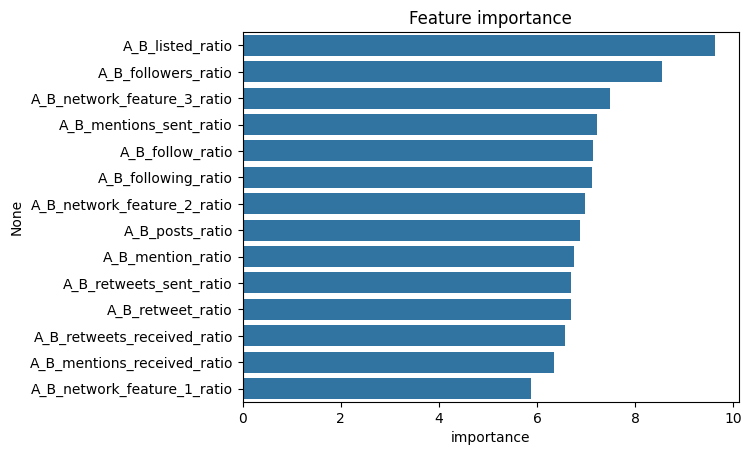

In [129]:
df_importance = pd.DataFrame(final_model.feature_importances_,final_model.feature_names_, columns = ['importance']).sort_values(by = 'importance', ascending = False)   
sns.barplot(x = df_importance['importance'], y = df_importance.index)
plt.title('Feature importance')

In [138]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(x_test)

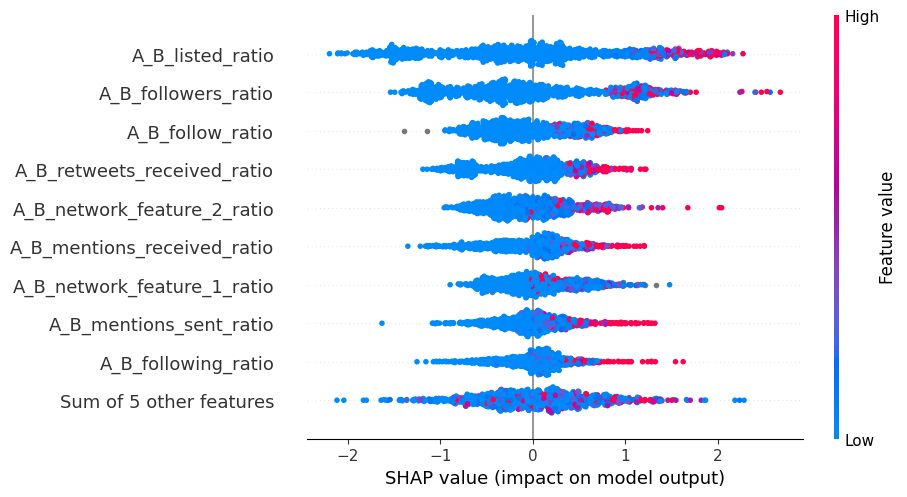

In [139]:
shap.plots.beeswarm(shap_values)

In [142]:
shap.initjs()
shap.plots.force(shap_values)

In [164]:
test = data.iloc[x_test.index]
test['preds'] = final_preds
test['revenue'] = np.where(
    (test['Choice'] == test['preds']) & (test['Choice']==1), (test['A_follower_count']*0.0003)-10, 
    np.where((test['Choice'] == test['preds']) & (test['Choice']==0), (test['B_follower_count']*0.0003)-10, 0))

test[['revenue']].sum()

revenue    311429.6136
dtype: float64

In [166]:
test['revenue_wo_analytics'] = np.where(test['Choice']==0, (test['B_follower_count']*0.0002)-5, 
                                        np.where(test['Choice']==1, (test['A_follower_count']*0.0002)-5, 0))
test[['revenue_wo_analytics']].sum()

revenue_wo_analytics    240676.8704
dtype: float64